Please ensure the following Python packages are installed:
pip install numpy matplotlib scikit-learn scipy trimesh open3d

3D Model Contour Similarity Analysis
Successfully loaded Model 1: 431646 vertices, 863288 faces
Successfully loaded Model 2: 9707 vertices, 45110 faces

Extracting contour feature points...
Model 1: Extracted 1000 contour feature points
Model 2: Extracted 1000 contour feature points

Computing similarity metrics...
Visualization saved to: similarity_analysis.png


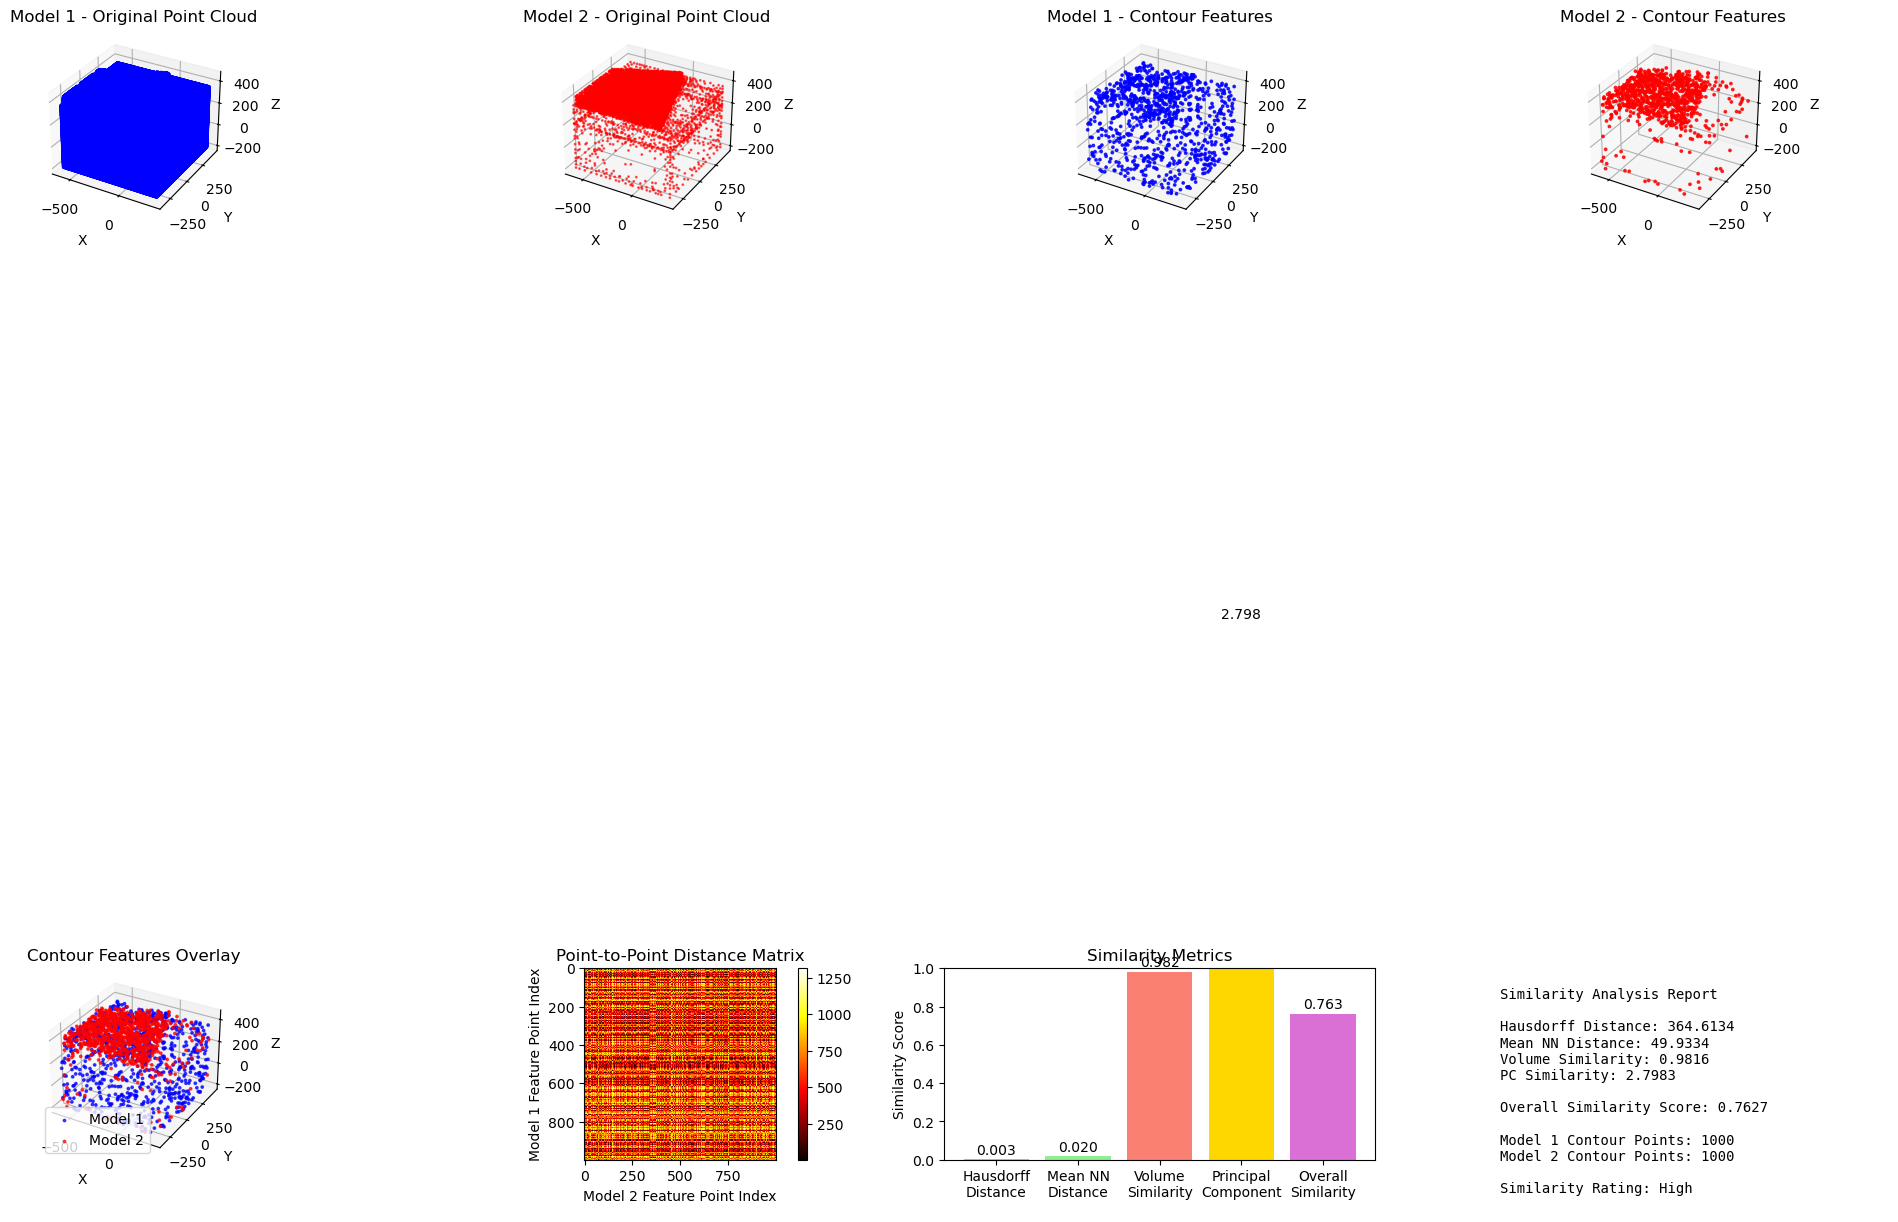


Analysis completed!
Overall similarity score: 0.7627


In [14]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import open3d as o3d
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import directed_hausdorff
import trimesh
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

class OBJSimilarityAnalyzer:
    def __init__(self):
        self.mesh1 = None
        self.mesh2 = None
        self.contour_points1 = None
        self.contour_points2 = None
        
    def load_obj_files(self, file1_path, file2_path):
        """Load two OBJ files"""
        try:
            # Load OBJ files using trimesh
            self.mesh1 = trimesh.load(file1_path)
            self.mesh2 = trimesh.load(file2_path)
            print(f"Successfully loaded Model 1: {len(self.mesh1.vertices)} vertices, {len(self.mesh1.faces)} faces")
            print(f"Successfully loaded Model 2: {len(self.mesh2.vertices)} vertices, {len(self.mesh2.faces)} faces")
            return True
        except Exception as e:
            print(f"Failed to load OBJ files: {e}")
            return False
    
    def extract_contour_features(self, mesh, n_samples=1000):
        """Extract contour feature points"""
        # Method 1: Boundary detection
        boundary_edges = mesh.outline()
        if boundary_edges is not None and len(boundary_edges.vertices) > 0:
            contour_points = boundary_edges.vertices
        else:
            # Method 2: Curvature-based contour extraction
            vertices = mesh.vertices
            
            # Calculate average normal vector for each vertex
            vertex_normals = mesh.vertex_normals
            
            # Find contour points (points with large normal vector changes)
            curvature_scores = []
            for i, vertex in enumerate(vertices):
                # Find neighboring vertices
                distances = np.linalg.norm(vertices - vertex, axis=1)
                neighbor_indices = np.argsort(distances)[1:11]  # Take 10 nearest neighbors
                
                # Calculate normal vector changes
                normal_diff = np.linalg.norm(
                    vertex_normals[neighbor_indices] - vertex_normals[i], axis=1
                ).mean()
                curvature_scores.append(normal_diff)
            
            # Select points with large curvature changes as contour points
            curvature_scores = np.array(curvature_scores)
            threshold = np.percentile(curvature_scores, 80)
            contour_indices = np.where(curvature_scores > threshold)[0]
            contour_points = vertices[contour_indices]
        
        # Downsample if too many contour points
        if len(contour_points) > n_samples:
            indices = np.random.choice(len(contour_points), n_samples, replace=False)
            contour_points = contour_points[indices]
            
        return contour_points
    
    def extract_silhouette_features(self, mesh, view_directions=None):
        """Extract contour features from multiple viewpoints"""
        if view_directions is None:
            # Default 6 viewpoints: front, back, left, right, top, bottom
            view_directions = [
                [0, 0, 1], [0, 0, -1],  # front, back
                [1, 0, 0], [-1, 0, 0],  # left, right
                [0, 1, 0], [0, -1, 0]   # top, bottom
            ]
        
        all_silhouette_points = []
        
        for view_dir in view_directions:
            view_dir = np.array(view_dir)
            vertices = mesh.vertices
            normals = mesh.vertex_normals
            
            # Calculate vertex visibility relative to view direction
            dot_products = np.dot(normals, view_dir)
            
            # Find silhouette edges (one face facing camera, one facing away)
            faces = mesh.faces
            face_dots = []
            
            for face in faces:
                face_normals = normals[face]
                face_dot = np.dot(face_normals.mean(axis=0), view_dir)
                face_dots.append(face_dot)
            
            face_dots = np.array(face_dots)
            
            # Find silhouette edges
            for i, face in enumerate(faces):
                for j in range(3):
                    # Check adjacent faces
                    edge_faces = []
                    edge = [face[j], face[(j+1)%3]]
                    
                    for k, other_face in enumerate(faces):
                        if k != i and (edge[0] in other_face and edge[1] in other_face):
                            edge_faces.append(k)
                    
                    # If the two faces on the boundary have different normal signs, it's a silhouette edge
                    if len(edge_faces) > 0:
                        if face_dots[i] * face_dots[edge_faces[0]] < 0:
                            # Add silhouette point
                            edge_midpoint = (vertices[edge[0]] + vertices[edge[1]]) / 2
                            all_silhouette_points.append(edge_midpoint)
        
        if len(all_silhouette_points) > 0:
            return np.array(all_silhouette_points)
        else:
            # Fallback: return boundary points
            return self.extract_contour_features(mesh)
    
    def compute_shape_descriptors(self, points):
        """Compute shape descriptors"""
        descriptors = {}
        
        # 1. Geometric center
        centroid = np.mean(points, axis=0)
        descriptors['centroid'] = centroid
        
        # 2. Principal Component Analysis
        pca = PCA(n_components=3)
        pca.fit(points - centroid)
        descriptors['principal_directions'] = pca.components_
        descriptors['principal_values'] = pca.explained_variance_
        
        # 3. Bounding box
        bbox_min = np.min(points, axis=0)
        bbox_max = np.max(points, axis=0)
        descriptors['bbox_size'] = bbox_max - bbox_min
        descriptors['bbox_volume'] = np.prod(bbox_max - bbox_min)
        
        # 4. Distance distribution
        distances_from_centroid = np.linalg.norm(points - centroid, axis=1)
        descriptors['mean_distance'] = np.mean(distances_from_centroid)
        descriptors['std_distance'] = np.std(distances_from_centroid)
        descriptors['max_distance'] = np.max(distances_from_centroid)
        
        return descriptors
    
    def compute_similarity_metrics(self):
        """Compute similarity metrics"""
        if self.contour_points1 is None or self.contour_points2 is None:
            print("Please extract contour feature points first")
            return None
        
        metrics = {}
        
        # 1. Hausdorff distance (contour similarity)
        hausdorff_1to2 = directed_hausdorff(self.contour_points1, self.contour_points2)[0]
        hausdorff_2to1 = directed_hausdorff(self.contour_points2, self.contour_points1)[0]
        hausdorff_distance = max(hausdorff_1to2, hausdorff_2to1)
        metrics['hausdorff_distance'] = hausdorff_distance
        
        # 2. Average nearest neighbor distance
        nbrs1 = NearestNeighbors(n_neighbors=1).fit(self.contour_points2)
        distances1, _ = nbrs1.kneighbors(self.contour_points1)
        mean_nn_dist1 = np.mean(distances1)
        
        nbrs2 = NearestNeighbors(n_neighbors=1).fit(self.contour_points1)
        distances2, _ = nbrs2.kneighbors(self.contour_points2)
        mean_nn_dist2 = np.mean(distances2)
        
        metrics['mean_nearest_neighbor_distance'] = (mean_nn_dist1 + mean_nn_dist2) / 2
        
        # 3. Shape descriptor similarity
        desc1 = self.compute_shape_descriptors(self.contour_points1)
        desc2 = self.compute_shape_descriptors(self.contour_points2)
        
        # Bounding box volume ratio
        volume_ratio = min(desc1['bbox_volume'], desc2['bbox_volume']) / max(desc1['bbox_volume'], desc2['bbox_volume'])
        metrics['volume_similarity'] = volume_ratio
        
        # Principal component similarity
        pc_similarity = np.abs(np.dot(desc1['principal_directions'].flatten(), 
                                    desc2['principal_directions'].flatten()))
        metrics['principal_component_similarity'] = pc_similarity
        
        # 4. Overall similarity score (0-1, 1 indicates perfect similarity)
        # Normalize metrics and calculate weighted average
        normalized_hausdorff = 1 / (1 + hausdorff_distance)
        normalized_nn_dist = 1 / (1 + metrics['mean_nearest_neighbor_distance'])
        
        overall_similarity = (
            0.3 * normalized_hausdorff +
            0.3 * normalized_nn_dist +
            0.2 * volume_ratio +
            0.2 * pc_similarity
        )
        metrics['overall_similarity'] = overall_similarity
        
        return metrics
    
    def visualize_comparison(self, save_path=None):
        """Visualize comparison results"""
        fig = plt.figure(figsize=(20, 12))
        
        # 1. Original model comparison
        ax1 = fig.add_subplot(2, 4, 1, projection='3d')
        if hasattr(self.mesh1, 'vertices'):
            ax1.scatter(self.mesh1.vertices[:, 0], self.mesh1.vertices[:, 1], 
                       self.mesh1.vertices[:, 2], alpha=0.6, s=1, c='blue')
        ax1.set_title('Model 1 - Original Point Cloud')
        ax1.set_xlabel('X')
        ax1.set_ylabel('Y')
        ax1.set_zlabel('Z')
        
        ax2 = fig.add_subplot(2, 4, 2, projection='3d')
        if hasattr(self.mesh2, 'vertices'):
            ax2.scatter(self.mesh2.vertices[:, 0], self.mesh2.vertices[:, 1], 
                       self.mesh2.vertices[:, 2], alpha=0.6, s=1, c='red')
        ax2.set_title('Model 2 - Original Point Cloud')
        ax2.set_xlabel('X')
        ax2.set_ylabel('Y')
        ax2.set_zlabel('Z')
        
        # 2. Contour feature points comparison
        ax3 = fig.add_subplot(2, 4, 3, projection='3d')
        if self.contour_points1 is not None:
            ax3.scatter(self.contour_points1[:, 0], self.contour_points1[:, 1], 
                       self.contour_points1[:, 2], alpha=0.8, s=3, c='blue')
        ax3.set_title('Model 1 - Contour Features')
        ax3.set_xlabel('X')
        ax3.set_ylabel('Y')
        ax3.set_zlabel('Z')
        
        ax4 = fig.add_subplot(2, 4, 4, projection='3d')
        if self.contour_points2 is not None:
            ax4.scatter(self.contour_points2[:, 0], self.contour_points2[:, 1], 
                       self.contour_points2[:, 2], alpha=0.8, s=3, c='red')
        ax4.set_title('Model 2 - Contour Features')
        ax4.set_xlabel('X')
        ax4.set_ylabel('Y')
        ax4.set_zlabel('Z')
        
        # 3. Overlay comparison
        ax5 = fig.add_subplot(2, 4, 5, projection='3d')
        if self.contour_points1 is not None and self.contour_points2 is not None:
            ax5.scatter(self.contour_points1[:, 0], self.contour_points1[:, 1], 
                       self.contour_points1[:, 2], alpha=0.7, s=3, c='blue', label='Model 1')
            ax5.scatter(self.contour_points2[:, 0], self.contour_points2[:, 1], 
                       self.contour_points2[:, 2], alpha=0.7, s=3, c='red', label='Model 2')
            ax5.legend()
        ax5.set_title('Contour Features Overlay')
        ax5.set_xlabel('X')
        ax5.set_ylabel('Y')
        ax5.set_zlabel('Z')
        
        # 4. Distance heatmap
        ax6 = fig.add_subplot(2, 4, 6)
        if self.contour_points1 is not None and self.contour_points2 is not None:
            # Compute point-to-point distance matrix
            from scipy.spatial.distance import cdist
            dist_matrix = cdist(self.contour_points1, self.contour_points2)
            im = ax6.imshow(dist_matrix, cmap='hot', interpolation='nearest')
            ax6.set_title('Point-to-Point Distance Matrix')
            ax6.set_xlabel('Model 2 Feature Point Index')
            ax6.set_ylabel('Model 1 Feature Point Index')
            plt.colorbar(im, ax=ax6)
        
        # 5. Similarity metrics visualization
        ax7 = fig.add_subplot(2, 4, 7)
        metrics = self.compute_similarity_metrics()
        if metrics:
            metric_names = ['Hausdorff\nDistance', 'Mean NN\nDistance', 'Volume\nSimilarity', 
                          'Principal\nComponent', 'Overall\nSimilarity']
            metric_values = [
                1/(1+metrics['hausdorff_distance']),  # normalized
                1/(1+metrics['mean_nearest_neighbor_distance']),  # normalized
                metrics['volume_similarity'],
                metrics['principal_component_similarity'],
                metrics['overall_similarity']
            ]
            
            bars = ax7.bar(metric_names, metric_values, 
                          color=['skyblue', 'lightgreen', 'salmon', 'gold', 'orchid'])
            ax7.set_title('Similarity Metrics')
            ax7.set_ylabel('Similarity Score')
            ax7.set_ylim(0, 1)
            
            # Add value labels
            for bar, value in zip(bars, metric_values):
                height = bar.get_height()
                ax7.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                        f'{value:.3f}', ha='center', va='bottom')
        
        # 6. Detailed statistics
        ax8 = fig.add_subplot(2, 4, 8)
        ax8.axis('off')
        if metrics:
            stats_text = f"""Similarity Analysis Report
            
Hausdorff Distance: {metrics['hausdorff_distance']:.4f}
Mean NN Distance: {metrics['mean_nearest_neighbor_distance']:.4f}
Volume Similarity: {metrics['volume_similarity']:.4f}
PC Similarity: {metrics['principal_component_similarity']:.4f}

Overall Similarity Score: {metrics['overall_similarity']:.4f}

Model 1 Contour Points: {len(self.contour_points1) if self.contour_points1 is not None else 0}
Model 2 Contour Points: {len(self.contour_points2) if self.contour_points2 is not None else 0}

Similarity Rating: {'Very High' if metrics['overall_similarity'] > 0.8 else 
                   'High' if metrics['overall_similarity'] > 0.6 else
                   'Medium' if metrics['overall_similarity'] > 0.4 else
                   'Low' if metrics['overall_similarity'] > 0.2 else 'Very Low'}
            """
            ax8.text(0.1, 0.9, stats_text, transform=ax8.transAxes, 
                    fontsize=10, verticalalignment='top', fontfamily='monospace')
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"Visualization saved to: {save_path}")
        
        plt.show()
        
        return metrics

def main():
    """Main function - Usage example"""
    # Create analyzer instance
    analyzer = OBJSimilarityAnalyzer()
    
    # Replace with your OBJ file paths
    file1_path = "../remote/Silicon_etch.obj" # Replace with actual file path
    file2_path = "../test/initial_struct.obj"  # Replace with actual file path
    
    print("3D Model Contour Similarity Analysis")
    print("=" * 50)
    
    # Load OBJ files
    if not analyzer.load_obj_files(file1_path, file2_path):
        print("Please ensure OBJ file paths are correct")
        return
    
    print("\nExtracting contour feature points...")
    
    # Extract contour feature points
    analyzer.contour_points1 = analyzer.extract_contour_features(analyzer.mesh1)
    analyzer.contour_points2 = analyzer.extract_contour_features(analyzer.mesh2)
    
    print(f"Model 1: Extracted {len(analyzer.contour_points1)} contour feature points")
    print(f"Model 2: Extracted {len(analyzer.contour_points2)} contour feature points")
    
    print("\nComputing similarity metrics...")
    
    # Compute similarity and visualize
    metrics = analyzer.visualize_comparison(save_path="similarity_analysis.png")
    
    print("\nAnalysis completed!")
    print(f"Overall similarity score: {metrics['overall_similarity']:.4f}")

if __name__ == "__main__":
    # Dependency installation reminder
    print("Please ensure the following Python packages are installed:")
    print("pip install numpy matplotlib scikit-learn scipy trimesh open3d")
    print()
    
    main()

In [15]:
file1 = "../remote/Silicon_etch.obj"
file2 = "../test/initial_struct.obj"

3D Model Cross-Sectional Comparison Tool
Loading 3D models...
Loaded 431646 vertices and 863288 faces from ../remote/Silicon_etch.obj
Loaded 9707 vertices and 22555 faces from ../test/initial_struct.obj

Performing cross-sectional comparison with 15 slices...
Processing slice 1/15 at x=-616.074
Processing slice 2/15 at x=-548.492
Processing slice 3/15 at x=-480.911
Processing slice 4/15 at x=-413.329
Processing slice 5/15 at x=-345.748
Processing slice 6/15 at x=-278.166
Processing slice 7/15 at x=-210.585
Processing slice 8/15 at x=-143.004
Processing slice 9/15 at x=-75.422
Processing slice 10/15 at x=-7.841
Processing slice 11/15 at x=59.741
Processing slice 12/15 at x=127.322
Processing slice 13/15 at x=194.904
Processing slice 14/15 at x=262.485
Processing slice 15/15 at x=330.067

Generating visualizations...
Visualization saved to model_comparison_results.png


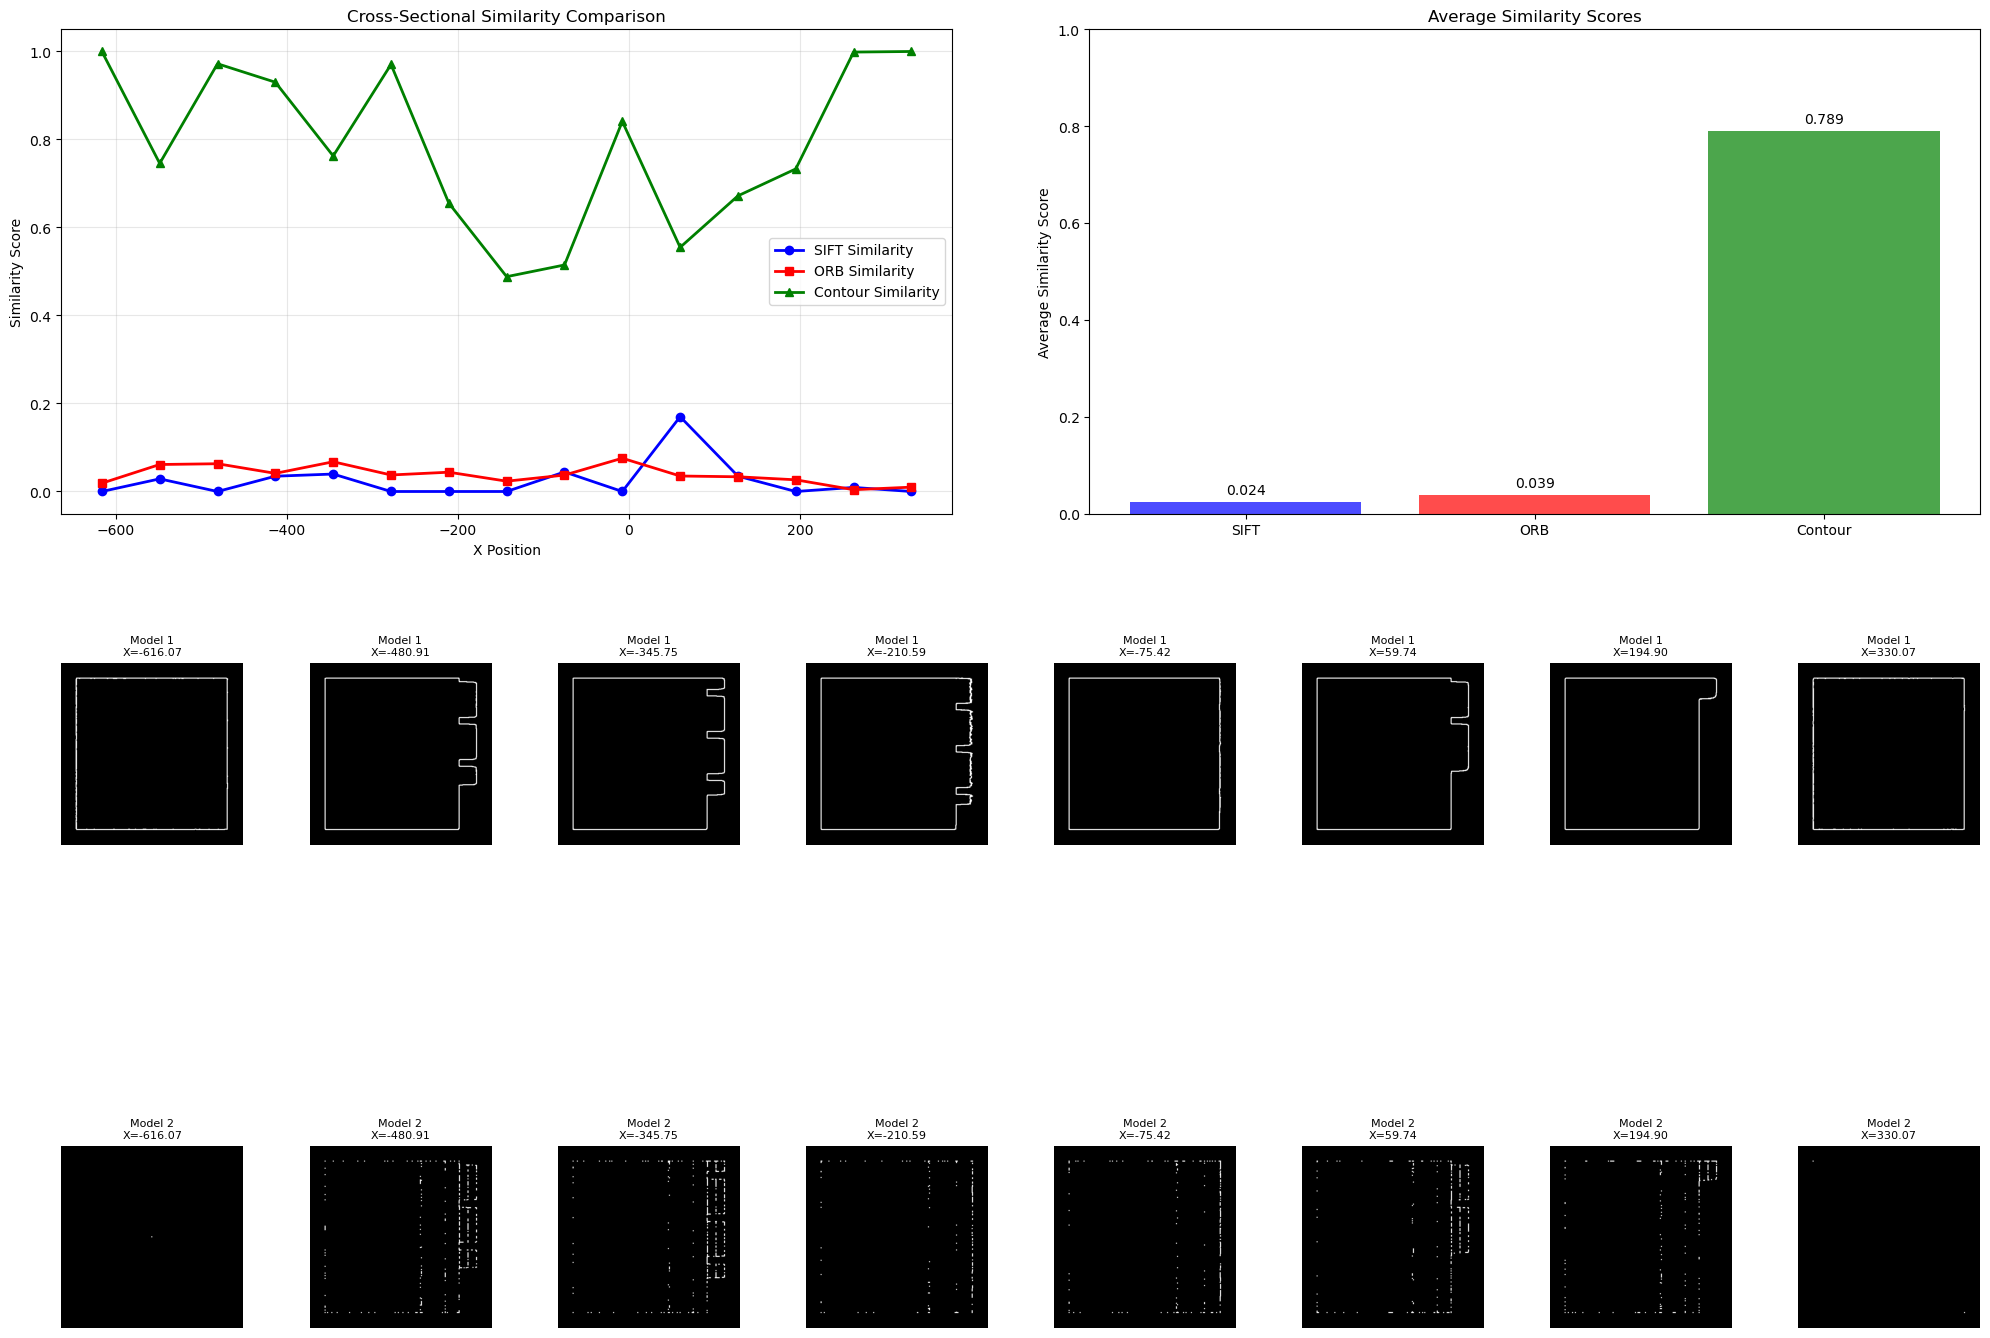


COMPARISON SUMMARY
Number of cross-sections analyzed: 15
X-range: -616.074 to 330.067

Average Similarity Scores:
  SIFT Feature Matching:  0.024
  ORB Feature Matching:   0.039
  Contour Shape Matching: 0.789

Overall Model Similarity: 0.284


In [28]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import cv2
from sklearn.metrics.pairwise import cosine_similarity
import os
from typing import List, Tuple, Dict
import warnings
warnings.filterwarnings('ignore')

class OBJLoader:
    """Load and parse Wavefront .obj files"""
    
    def __init__(self, filepath: str):
        self.filepath = filepath
        self.vertices = []
        self.faces = []
        self.load_obj()
    
    def load_obj(self):
        """Parse .obj file and extract vertices and faces"""
        try:
            with open(self.filepath, 'r') as file:
                for line_num, line in enumerate(file, 1):
                    line = line.strip()
                    if line.startswith('v '):
                        # Vertex coordinates
                        try:
                            coords = line.split()[1:4]
                            if len(coords) >= 3:
                                vertex = [float(coord) for coord in coords[:3]]
                                # Validate vertex coordinates
                                if all(np.isfinite(vertex)):
                                    self.vertices.append(vertex)
                                else:
                                    print(f"Warning: Invalid vertex at line {line_num}: {coords}")
                        except (ValueError, IndexError) as e:
                            print(f"Warning: Could not parse vertex at line {line_num}: {line}")
                            continue
                            
                    elif line.startswith('f '):
                        # Face indices (convert to 0-based indexing)
                        try:
                            indices = []
                            for face_data in line.split()[1:]:
                                # Handle different face formats (v, v/vt, v/vt/vn)
                                vertex_idx = int(face_data.split('/')[0]) - 1
                                indices.append(vertex_idx)
                            
                            # Validate face indices
                            if len(indices) >= 3 and all(0 <= idx < len(self.vertices) for idx in indices):
                                self.faces.append(indices)
                            else:
                                print(f"Warning: Invalid face at line {line_num}: {indices}")
                                
                        except (ValueError, IndexError) as e:
                            print(f"Warning: Could not parse face at line {line_num}: {line}")
                            continue
            
            self.vertices = np.array(self.vertices)
            
            if len(self.vertices) == 0:
                raise ValueError("No valid vertices found in the OBJ file")
            if len(self.faces) == 0:
                raise ValueError("No valid faces found in the OBJ file")
                
            print(f"Loaded {len(self.vertices)} vertices and {len(self.faces)} faces from {self.filepath}")
            
        except FileNotFoundError:
            print(f"Error: File {self.filepath} not found")
            raise
        except Exception as e:
            print(f"Error loading {self.filepath}: {str(e)}")
            raise

class CrossSectionAnalyzer:
    """Analyze cross-sections of 3D models"""
    
    def __init__(self, obj_loader: OBJLoader):
        self.obj_loader = obj_loader
        self.vertices = obj_loader.vertices
        self.faces = obj_loader.faces
        
    def get_x_bounds(self) -> Tuple[float, float]:
        """Get the x-axis bounds of the model"""
        if len(self.vertices) == 0:
            return 0.0, 1.0
        
        # Filter out non-finite values
        x_coords = self.vertices[:, 0]
        finite_mask = np.isfinite(x_coords)
        
        if not np.any(finite_mask):
            return 0.0, 1.0
        
        valid_x_coords = x_coords[finite_mask]
        return float(np.min(valid_x_coords)), float(np.max(valid_x_coords))
    
    def slice_at_x(self, x_position: float, tolerance: float = 0.01) -> List[Tuple[float, float]]:
        """Extract cross-section points at given x position"""
        cross_section_points = []
        
        for face in self.faces:
            if len(face) < 3:
                continue
            
            try:
                # Get vertices of the face
                face_vertices = self.vertices[face]
                
                # Skip faces with invalid vertices
                if not np.all(np.isfinite(face_vertices)):
                    continue
                
                # Check each edge of the face for intersection with x-plane
                num_vertices = len(face_vertices)
                for i in range(num_vertices):
                    v1 = face_vertices[i]
                    v2 = face_vertices[(i + 1) % num_vertices]
                    
                    # Skip if vertices contain NaN or inf
                    if not (np.all(np.isfinite(v1)) and np.all(np.isfinite(v2))):
                        continue
                    
                    # Check if edge crosses the x-plane
                    if (v1[0] <= x_position <= v2[0]) or (v2[0] <= x_position <= v1[0]):
                        x_diff = abs(v1[0] - v2[0])
                        if x_diff > 1e-10:  # Avoid division by zero
                            # Linear interpolation to find intersection point
                            t = (x_position - v1[0]) / (v2[0] - v1[0])
                            
                            # Ensure t is in valid range
                            if 0.0 <= t <= 1.0:
                                y = v1[1] + t * (v2[1] - v1[1])
                                z = v1[2] + t * (v2[2] - v1[2])
                                
                                # Only add finite points
                                if np.isfinite(y) and np.isfinite(z):
                                    cross_section_points.append((float(y), float(z)))
            except (IndexError, ValueError) as e:
                # Skip problematic faces
                continue
        
        # Remove duplicate points with tolerance
        if cross_section_points:
            unique_points = []
            tolerance_sq = tolerance * tolerance
            
            for point in cross_section_points:
                is_duplicate = False
                for existing_point in unique_points:
                    dist_sq = (point[0] - existing_point[0])**2 + (point[1] - existing_point[1])**2
                    if dist_sq < tolerance_sq:
                        is_duplicate = True
                        break
                
                if not is_duplicate:
                    unique_points.append(point)
            
            cross_section_points = unique_points
        
        return cross_section_points
    
    def generate_cross_section_image(self, cross_section_points: List[Tuple[float, float]], 
                                   image_size: Tuple[int, int] = (512, 512)) -> np.ndarray:
        """Convert cross-section points to binary image"""
        if not cross_section_points:
            return np.zeros(image_size, dtype=np.uint8)
        
        points = np.array(cross_section_points)
        
        # Remove any NaN or infinite values
        valid_mask = np.isfinite(points).all(axis=1)
        points = points[valid_mask]
        
        if len(points) == 0:
            return np.zeros(image_size, dtype=np.uint8)
        
        # Normalize points to image coordinates
        y_min, y_max = np.min(points[:, 0]), np.max(points[:, 0])
        z_min, z_max = np.min(points[:, 1]), np.max(points[:, 1])
        
        # Handle case where all points are the same (range is zero)
        y_range = y_max - y_min
        z_range = z_max - z_min
        
        # If range is zero or very small, create a small artificial range
        min_range = 1e-6
        if y_range < min_range:
            y_center = (y_min + y_max) / 2
            y_min = y_center - min_range / 2
            y_max = y_center + min_range / 2
            y_range = min_range
            
        if z_range < min_range:
            z_center = (z_min + z_max) / 2
            z_min = z_center - min_range / 2
            z_max = z_center + min_range / 2
            z_range = min_range
        
        # Add padding
        padding = 0.1
        y_min -= y_range * padding
        y_max += y_range * padding
        z_min -= z_range * padding
        z_max += z_range * padding
        
        # Recalculate ranges after padding
        y_range = y_max - y_min
        z_range = z_max - z_min
        
        # Convert to image coordinates
        img = np.zeros(image_size, dtype=np.uint8)
        
        for y, z in points:
            # Skip invalid points
            if not (np.isfinite(y) and np.isfinite(z)):
                continue
                
            # Calculate image coordinates with bounds checking
            img_y_float = (y - y_min) / y_range * (image_size[0] - 1)
            img_z_float = (z - z_min) / z_range * (image_size[1] - 1)
            
            # Check for NaN before conversion
            if np.isfinite(img_y_float) and np.isfinite(img_z_float):
                img_y = int(np.clip(img_y_float, 0, image_size[0] - 1))
                img_z = int(np.clip(img_z_float, 0, image_size[1] - 1))
                img[img_y, img_z] = 255
        
        # Apply morphological operations to create a better contour
        if np.any(img > 0):  # Only apply if there are any points
            kernel = np.ones((3, 3), np.uint8)
            img = cv2.dilate(img, kernel, iterations=2)
            img = cv2.erode(img, kernel, iterations=1)
        
        return img

class FeatureMatchingComparator:
    """Compare images using feature matching algorithms"""
    
    def __init__(self):
        # Initialize feature detectors
        self.sift = cv2.SIFT_create()
        self.orb = cv2.ORB_create()
        
    def extract_sift_features(self, img: np.ndarray) -> Tuple[List, np.ndarray]:
        """Extract SIFT features from image"""
        keypoints, descriptors = self.sift.detectAndCompute(img, None)
        return keypoints, descriptors
    
    def extract_orb_features(self, img: np.ndarray) -> Tuple[List, np.ndarray]:
        """Extract ORB features from image"""
        keypoints, descriptors = self.orb.detectAndCompute(img, None)
        return keypoints, descriptors
    
    def match_features_sift(self, desc1: np.ndarray, desc2: np.ndarray) -> float:
        """Match SIFT features and calculate similarity"""
        if desc1 is None or desc2 is None or len(desc1) == 0 or len(desc2) == 0:
            return 0.0
        
        # FLANN matcher for SIFT
        FLANN_INDEX_KDTREE = 1
        index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
        search_params = dict(checks=50)
        flann = cv2.FlannBasedMatcher(index_params, search_params)
        
        try:
            matches = flann.knnMatch(desc1, desc2, k=2)
            
            # Apply Lowe's ratio test
            good_matches = []
            for match_pair in matches:
                if len(match_pair) == 2:
                    m, n = match_pair
                    if m.distance < 0.7 * n.distance:
                        good_matches.append(m)
            
            # Calculate similarity based on good matches
            max_features = max(len(desc1), len(desc2))
            similarity = len(good_matches) / max_features if max_features > 0 else 0.0
            return min(similarity, 1.0)
            
        except Exception as e:
            print(f"SIFT matching error: {e}")
            return 0.0
    
    def match_features_orb(self, desc1: np.ndarray, desc2: np.ndarray) -> float:
        """Match ORB features and calculate similarity"""
        if desc1 is None or desc2 is None or len(desc1) == 0 or len(desc2) == 0:
            return 0.0
        
        # BFMatcher for ORB
        bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
        
        try:
            matches = bf.match(desc1, desc2)
            matches = sorted(matches, key=lambda x: x.distance)
            
            # Calculate similarity based on good matches (distance < threshold)
            good_matches = [m for m in matches if m.distance < 50]
            max_features = max(len(desc1), len(desc2))
            similarity = len(good_matches) / max_features if max_features > 0 else 0.0
            return min(similarity, 1.0)
            
        except Exception as e:
            print(f"ORB matching error: {e}")
            return 0.0
    
    def calculate_contour_similarity(self, img1: np.ndarray, img2: np.ndarray) -> float:
        """Calculate contour-based similarity"""
        # Find contours
        contours1, _ = cv2.findContours(img1, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        contours2, _ = cv2.findContours(img2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        if not contours1 or not contours2:
            return 0.0
        
        # Get the largest contour from each image
        contour1 = max(contours1, key=cv2.contourArea)
        contour2 = max(contours2, key=cv2.contourArea)
        
        # Calculate Hu moments
        moments1 = cv2.moments(contour1)
        moments2 = cv2.moments(contour2)
        
        hu1 = cv2.HuMoments(moments1).flatten()
        hu2 = cv2.HuMoments(moments2).flatten()
        
        # Calculate similarity using cosine similarity
        hu1 = hu1.reshape(1, -1)
        hu2 = hu2.reshape(1, -1)
        
        similarity = cosine_similarity(hu1, hu2)[0][0]
        return max(0.0, similarity)  # Ensure non-negative

class ModelComparator:
    """Main class for comparing two 3D models"""
    
    def __init__(self, obj_path1: str, obj_path2: str):
        self.obj_path1 = obj_path1
        self.obj_path2 = obj_path2
        
        print("Loading 3D models...")
        self.loader1 = OBJLoader(obj_path1)
        self.loader2 = OBJLoader(obj_path2)
        
        self.analyzer1 = CrossSectionAnalyzer(self.loader1)
        self.analyzer2 = CrossSectionAnalyzer(self.loader2)
        
        self.comparator = FeatureMatchingComparator()
        
    def compare_models(self, num_slices: int = 10) -> Dict:
        """Compare two models using cross-sectional analysis"""
        print(f"\nPerforming cross-sectional comparison with {num_slices} slices...")
        
        # Get x-bounds for both models
        x_min1, x_max1 = self.analyzer1.get_x_bounds()
        x_min2, x_max2 = self.analyzer2.get_x_bounds()
        
        # Use overlapping region
        x_min = max(x_min1, x_min2)
        x_max = min(x_max1, x_max2)
        
        if x_min >= x_max:
            print("Warning: Models don't overlap in x-direction")
            x_min = min(x_min1, x_min2)
            x_max = max(x_max1, x_max2)
        
        # Generate slice positions
        x_positions = np.linspace(x_min, x_max, num_slices)
        
        results = {
            'x_positions': x_positions,
            'sift_similarities': [],
            'orb_similarities': [],
            'contour_similarities': [],
            'cross_sections1': [],
            'cross_sections2': [],
            'images1': [],
            'images2': []
        }
        
        for i, x_pos in enumerate(x_positions):
            print(f"Processing slice {i+1}/{num_slices} at x={x_pos:.3f}")
            
            # Get cross-sections
            points1 = self.analyzer1.slice_at_x(x_pos)
            points2 = self.analyzer2.slice_at_x(x_pos)
            
            results['cross_sections1'].append(points1)
            results['cross_sections2'].append(points2)
            
            # Generate images
            img1 = self.analyzer1.generate_cross_section_image(points1)
            img2 = self.analyzer2.generate_cross_section_image(points2)
            
            results['images1'].append(img1)
            results['images2'].append(img2)
            
            # Extract features and calculate similarities
            kp1_sift, desc1_sift = self.comparator.extract_sift_features(img1)
            kp2_sift, desc2_sift = self.comparator.extract_sift_features(img2)
            
            kp1_orb, desc1_orb = self.comparator.extract_orb_features(img1)
            kp2_orb, desc2_orb = self.comparator.extract_orb_features(img2)
            
            sift_sim = self.comparator.match_features_sift(desc1_sift, desc2_sift)
            orb_sim = self.comparator.match_features_orb(desc1_orb, desc2_orb)
            contour_sim = self.comparator.calculate_contour_similarity(img1, img2)
            
            results['sift_similarities'].append(sift_sim)
            results['orb_similarities'].append(orb_sim)
            results['contour_similarities'].append(contour_sim)
        
        return results
    
    def visualize_results(self, results: Dict, save_path: str = None):
        """Visualize comparison results"""
        print("\nGenerating visualizations...")
        
        num_slices = len(results['x_positions'])
        
        # Create comprehensive visualization
        fig = plt.figure(figsize=(20, 15))
        
        # 1. Similarity scores plot
        ax1 = plt.subplot(3, 4, (1, 2))
        x_pos = results['x_positions']
        
        plt.plot(x_pos, results['sift_similarities'], 'b-o', label='SIFT Similarity', linewidth=2)
        plt.plot(x_pos, results['orb_similarities'], 'r-s', label='ORB Similarity', linewidth=2)
        plt.plot(x_pos, results['contour_similarities'], 'g-^', label='Contour Similarity', linewidth=2)
        
        plt.xlabel('X Position')
        plt.ylabel('Similarity Score')
        plt.title('Cross-Sectional Similarity Comparison')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # 2. Average similarity bar chart
        ax2 = plt.subplot(3, 4, (3, 4))
        avg_sift = np.mean(results['sift_similarities'])
        avg_orb = np.mean(results['orb_similarities'])
        avg_contour = np.mean(results['contour_similarities'])
        
        methods = ['SIFT', 'ORB', 'Contour']
        scores = [avg_sift, avg_orb, avg_contour]
        colors = ['blue', 'red', 'green']
        
        bars = plt.bar(methods, scores, color=colors, alpha=0.7)
        plt.ylabel('Average Similarity Score')
        plt.title('Average Similarity Scores')
        plt.ylim(0, 1)
        
        # Add value labels on bars
        for bar, score in zip(bars, scores):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                    f'{score:.3f}', ha='center', va='bottom')
        
        # 3. Cross-section visualizations (show a few representative slices)
        slice_indices = np.linspace(0, num_slices-1, min(8, num_slices), dtype=int)
        
        for i, slice_idx in enumerate(slice_indices):
            if i >= 8:
                break
                
            # Model 1 cross-section
            ax = plt.subplot(3, 8, i + 9)
            img1 = results['images1'][slice_idx]
            plt.imshow(img1, cmap='gray')
            plt.title(f'Model 1\nX={results["x_positions"][slice_idx]:.2f}', fontsize=8)
            plt.axis('off')
            
            # Model 2 cross-section
            ax = plt.subplot(3, 8, i + 17)
            img2 = results['images2'][slice_idx]
            plt.imshow(img2, cmap='gray')
            plt.title(f'Model 2\nX={results["x_positions"][slice_idx]:.2f}', fontsize=8)
            plt.axis('off')
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"Visualization saved to {save_path}")
        
        plt.show()
        
        # Print summary statistics
        print("\n" + "="*50)
        print("COMPARISON SUMMARY")
        print("="*50)
        print(f"Number of cross-sections analyzed: {num_slices}")
        print(f"X-range: {results['x_positions'][0]:.3f} to {results['x_positions'][-1]:.3f}")
        print(f"\nAverage Similarity Scores:")
        print(f"  SIFT Feature Matching:  {avg_sift:.3f}")
        print(f"  ORB Feature Matching:   {avg_orb:.3f}")
        print(f"  Contour Shape Matching: {avg_contour:.3f}")
        print(f"\nOverall Model Similarity: {np.mean([avg_sift, avg_orb, avg_contour]):.3f}")
        print("="*50)

# Example usage and demonstration
def main():
    """Main function demonstrating the usage"""
    print("3D Model Cross-Sectional Comparison Tool")
    print("="*40)
    
    # Note: Replace these paths with your actual .obj file paths
    obj_path1 = file1  # Path to first .obj file
    obj_path2 = file2  # Path to second .obj file
    
    try:
        # Create comparator instance
        comparator = ModelComparator(obj_path1, obj_path2)
        
        # Perform comparison
        results = comparator.compare_models(num_slices=15)
        
        # Visualize results
        comparator.visualize_results(results, save_path="model_comparison_results.png")
        
    except FileNotFoundError:
        print("\nDemo Mode: .obj files not found")
        print("To use this tool:")
        print("1. Place your .obj files in the same directory")
        print("2. Update the file paths in the main() function")
        print("3. Run the script again")
        
        # Create sample data for demonstration
        create_demo_visualization()

def create_demo_visualization():
    """Create a demonstration visualization with sample data"""
    print("\nCreating demonstration visualization...")
    
    # Generate sample similarity data
    x_positions = np.linspace(0, 10, 15)
    sift_sim = 0.7 + 0.2 * np.sin(x_positions) + np.random.normal(0, 0.05, len(x_positions))
    orb_sim = 0.6 + 0.15 * np.cos(x_positions) + np.random.normal(0, 0.05, len(x_positions))
    contour_sim = 0.8 + 0.1 * np.sin(2*x_positions) + np.random.normal(0, 0.03, len(x_positions))
    
    # Ensure values are in [0, 1] range
    sift_sim = np.clip(sift_sim, 0, 1)
    orb_sim = np.clip(orb_sim, 0, 1)
    contour_sim = np.clip(contour_sim, 0, 1)
    
    # Create visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Similarity plot
    ax1.plot(x_positions, sift_sim, 'b-o', label='SIFT Similarity', linewidth=2)
    ax1.plot(x_positions, orb_sim, 'r-s', label='ORB Similarity', linewidth=2)
    ax1.plot(x_positions, contour_sim, 'g-^', label='Contour Similarity', linewidth=2)
    
    ax1.set_xlabel('X Position')
    ax1.set_ylabel('Similarity Score')
    ax1.set_title('Cross-Sectional Similarity Comparison (Demo)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Average similarity
    methods = ['SIFT', 'ORB', 'Contour']
    scores = [np.mean(sift_sim), np.mean(orb_sim), np.mean(contour_sim)]
    colors = ['blue', 'red', 'green']
    
    bars = ax2.bar(methods, scores, color=colors, alpha=0.7)
    ax2.set_ylabel('Average Similarity Score')
    ax2.set_title('Average Similarity Scores (Demo)')
    ax2.set_ylim(0, 1)
    
    for bar, score in zip(bars, scores):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                f'{score:.3f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.savefig("demo_comparison_results.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    print("Demo visualization saved as 'demo_comparison_results.png'")

if __name__ == "__main__":
    main()

Loaded 431646 vertices and 863288 faces from ../remote/Silicon_etch.obj
Loaded 9707 vertices and 22555 faces from ../test/initial_struct.obj
X-axis range: [-616.074, 330.067]
Starting cross-section comparison...
Processing slice 1/15 at x=-616.074
  Keypoints: 42, 0 | Matches: 0 | Similarity: 0.000
Processing slice 2/15 at x=-548.492
  Keypoints: 75, 174 | Matches: 4 | Similarity: 0.023
Processing slice 3/15 at x=-480.911
  Keypoints: 55, 169 | Matches: 4 | Similarity: 0.024
Processing slice 4/15 at x=-413.329
  Keypoints: 38, 179 | Matches: 4 | Similarity: 0.022
Processing slice 5/15 at x=-345.748
  Keypoints: 67, 197 | Matches: 12 | Similarity: 0.061
Processing slice 6/15 at x=-278.166
  Keypoints: 50, 139 | Matches: 2 | Similarity: 0.014
Processing slice 7/15 at x=-210.585
  Keypoints: 177, 82 | Matches: 1 | Similarity: 0.006
Processing slice 8/15 at x=-143.004
  Keypoints: 12, 57 | Matches: 1 | Similarity: 0.018
Processing slice 9/15 at x=-75.422
  Keypoints: 89, 75 | Matches: 1 | 

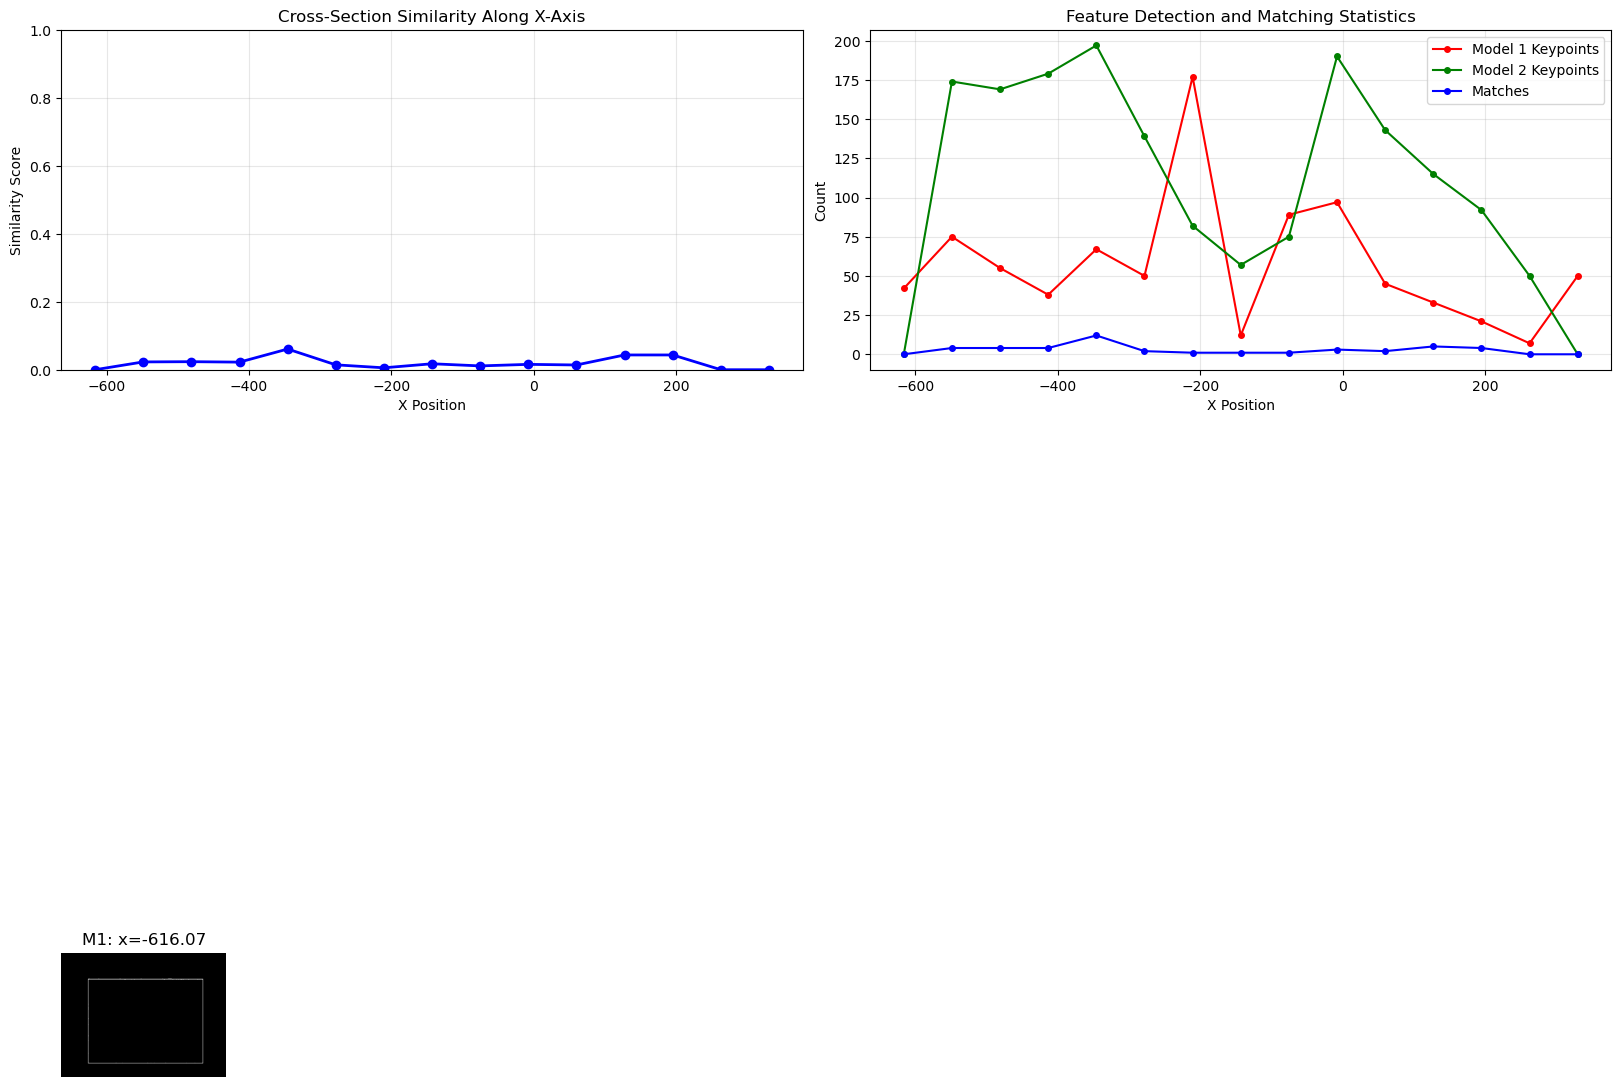

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import cv2
from matplotlib.patches import Polygon
from matplotlib.collections import LineCollection
import os
from typing import List, Tuple, Dict
import warnings
warnings.filterwarnings('ignore')

class OBJLoader:
    """Load and parse Wavefront .obj files"""
    
    def __init__(self, filepath: str):
        self.vertices = []
        self.faces = []
        self.load_obj(filepath)
    
    def load_obj(self, filepath: str):
        """Load vertices and faces from .obj file"""
        with open(filepath, 'r') as file:
            for line in file:
                if line.startswith('v '):
                    # Vertex coordinates
                    coords = list(map(float, line.strip().split()[1:]))
                    self.vertices.append(coords[:3])  # Take only x, y, z
                elif line.startswith('f '):
                    # Face indices (convert to 0-based indexing)
                    face_data = line.strip().split()[1:]
                    face = []
                    for vertex_data in face_data:
                        # Handle different face formats (v, v/vt, v/vt/vn)
                        vertex_idx = int(vertex_data.split('/')[0]) - 1
                        face.append(vertex_idx)
                    self.faces.append(face)
        
        self.vertices = np.array(self.vertices)
        print(f"Loaded {len(self.vertices)} vertices and {len(self.faces)} faces from {filepath}")

class CrossSectionExtractor:
    """Extract cross-sections from 3D models"""
    
    def __init__(self, obj_loader: OBJLoader):
        self.vertices = obj_loader.vertices
        self.faces = obj_loader.faces
        self.x_min = np.min(self.vertices[:, 0])
        self.x_max = np.max(self.vertices[:, 0])
    
    def extract_cross_section(self, x_position: float, tolerance: float = 0.01) -> List[np.ndarray]:
        """Extract cross-section at given x position"""
        cross_section_lines = []
        
        for face in self.faces:
            if len(face) < 3:
                continue
                
            # Get vertices of the face
            face_vertices = self.vertices[face]
            
            # Find intersections with the x-plane
            intersections = []
            
            for i in range(len(face_vertices)):
                v1 = face_vertices[i]
                v2 = face_vertices[(i + 1) % len(face_vertices)]
                
                # Check if edge crosses the x-plane
                if (v1[0] <= x_position <= v2[0]) or (v2[0] <= x_position <= v1[0]):
                    if abs(v1[0] - v2[0]) > 1e-10:  # Avoid division by zero
                        # Linear interpolation to find intersection point
                        t = (x_position - v1[0]) / (v2[0] - v1[0])
                        intersection = v1 + t * (v2 - v1)
                        intersections.append(intersection[1:])  # Take y, z coordinates
            
            # If we have exactly 2 intersections, we have a line segment
            if len(intersections) == 2:
                cross_section_lines.append(np.array(intersections))
        
        return cross_section_lines
    
    def get_cross_section_bounds(self) -> Tuple[float, float]:
        """Get the x-axis bounds for cross-sectioning"""
        return self.x_min, self.x_max

class CrossSectionVisualizer:
    """Visualize and compare cross-sections"""
    
    def __init__(self, img_size: Tuple[int, int] = (800, 600)):
        self.img_size = img_size
    
    def render_cross_section(self, cross_section_lines: List[np.ndarray], 
                           bounds: Tuple[Tuple[float, float], Tuple[float, float]]) -> np.ndarray:
        """Render cross-section as binary image"""
        if not cross_section_lines:
            return np.zeros(self.img_size, dtype=np.uint8)
        
        # Create figure and axis
        fig, ax = plt.subplots(figsize=(8, 6))
        ax.set_xlim(bounds[0])
        ax.set_ylim(bounds[1])
        ax.set_aspect('equal')
        ax.axis('off')
        
        # Draw cross-section lines
        for line in cross_section_lines:
            if len(line) == 2:
                ax.plot([line[0][0], line[1][0]], [line[0][1], line[1][1]], 'k-', linewidth=2)
        
        # Convert to image
        fig.canvas.draw()
        buf = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
        buf = buf.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        
        # Convert to grayscale and binary
        gray = cv2.cvtColor(buf, cv2.COLOR_RGB2GRAY)
        _, binary = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV)
        
        plt.close(fig)
        
        # Resize to target size
        binary = cv2.resize(binary, self.img_size)
        return binary

class SIFTMatcher:
    """SIFT feature matching with FLANN"""
    
    def __init__(self):
        self.sift = cv2.SIFT_create()
        
        # FLANN parameters
        FLANN_INDEX_KDTREE = 1
        index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
        search_params = dict(checks=50)
        self.flann = cv2.FlannBasedMatcher(index_params, search_params)
    
    def extract_features(self, image: np.ndarray) -> Tuple[List, np.ndarray]:
        """Extract SIFT features from image"""
        keypoints, descriptors = self.sift.detectAndCompute(image, None)
        return keypoints, descriptors
    
    def match_features(self, desc1: np.ndarray, desc2: np.ndarray) -> List:
        """Match features using FLANN"""
        if desc1 is None or desc2 is None or len(desc1) < 2 or len(desc2) < 2:
            return []
        
        try:
            matches = self.flann.knnMatch(desc1, desc2, k=2)
            
            # Apply Lowe's ratio test
            good_matches = []
            for match_pair in matches:
                if len(match_pair) == 2:
                    m, n = match_pair
                    if m.distance < 0.7 * n.distance:
                        good_matches.append(m)
            
            return good_matches
        except:
            return []
    
    def calculate_similarity(self, matches: List, kp1: List, kp2: List) -> float:
        """Calculate similarity score based on matches"""
        if not matches or not kp1 or not kp2:
            return 0.0
        
        # Normalize by the number of keypoints
        max_features = max(len(kp1), len(kp2))
        if max_features == 0:
            return 0.0
        
        similarity = len(matches) / max_features
        return min(similarity, 1.0)  # Cap at 1.0

class CrossSectionComparator:
    """Main class for comparing cross-sections of two OBJ files"""
    
    def __init__(self, obj_file1: str, obj_file2: str):
        self.obj1 = OBJLoader(obj_file1)
        self.obj2 = OBJLoader(obj_file2)
        
        self.extractor1 = CrossSectionExtractor(self.obj1)
        self.extractor2 = CrossSectionExtractor(self.obj2)
        
        self.visualizer = CrossSectionVisualizer()
        self.matcher = SIFTMatcher()
        
        # Determine common x-bounds
        self.x_min = max(self.extractor1.x_min, self.extractor2.x_min)
        self.x_max = min(self.extractor1.x_max, self.extractor2.x_max)
        
        # Determine y-z bounds for visualization
        all_vertices = np.vstack([self.obj1.vertices, self.obj2.vertices])
        self.y_bounds = (np.min(all_vertices[:, 1]), np.max(all_vertices[:, 1]))
        self.z_bounds = (np.min(all_vertices[:, 2]), np.max(all_vertices[:, 2]))
        
        print(f"X-axis range: [{self.x_min:.3f}, {self.x_max:.3f}]")
    
    def compare_cross_sections(self, num_slices: int = 10) -> Dict:
        """Compare cross-sections at multiple x positions"""
        x_positions = np.linspace(self.x_min, self.x_max, num_slices)
        results = {
            'x_positions': x_positions,
            'similarities': [],
            'images1': [],
            'images2': [],
            'matches_count': [],
            'keypoints_count1': [],
            'keypoints_count2': []
        }
        
        bounds = (self.y_bounds, self.z_bounds)
        
        for i, x_pos in enumerate(x_positions):
            print(f"Processing slice {i+1}/{num_slices} at x={x_pos:.3f}")
            
            # Extract cross-sections
            cs1 = self.extractor1.extract_cross_section(x_pos)
            cs2 = self.extractor2.extract_cross_section(x_pos)
            
            # Render as images
            img1 = self.visualizer.render_cross_section(cs1, bounds)
            img2 = self.visualizer.render_cross_section(cs2, bounds)
            
            # Extract features
            kp1, desc1 = self.matcher.extract_features(img1)
            kp2, desc2 = self.matcher.extract_features(img2)
            
            # Match features
            matches = self.matcher.match_features(desc1, desc2)
            
            # Calculate similarity
            similarity = self.matcher.calculate_similarity(matches, kp1, kp2)
            
            # Store results
            results['similarities'].append(similarity)
            results['images1'].append(img1)
            results['images2'].append(img2)
            results['matches_count'].append(len(matches))
            results['keypoints_count1'].append(len(kp1))
            results['keypoints_count2'].append(len(kp2))
            
            print(f"  Keypoints: {len(kp1)}, {len(kp2)} | Matches: {len(matches)} | Similarity: {similarity:.3f}")
        
        return results
    
    def visualize_results(self, results: Dict, save_path: str = None):
        """Visualize comparison results"""
        n_slices = len(results['x_positions'])
        
        # Create comprehensive visualization
        fig = plt.figure(figsize=(20, 15))
        
        # Plot 1: Similarity curve
        plt.subplot(3, 4, (1, 2))
        plt.plot(results['x_positions'], results['similarities'], 'b-o', linewidth=2, markersize=6)
        plt.xlabel('X Position')
        plt.ylabel('Similarity Score')
        plt.title('Cross-Section Similarity Along X-Axis')
        plt.grid(True, alpha=0.3)
        plt.ylim(0, 1)
        
        # Plot 2: Feature counts
        plt.subplot(3, 4, (3, 4))
        plt.plot(results['x_positions'], results['keypoints_count1'], 'r-o', label='Model 1 Keypoints', markersize=4)
        plt.plot(results['x_positions'], results['keypoints_count2'], 'g-o', label='Model 2 Keypoints', markersize=4)
        plt.plot(results['x_positions'], results['matches_count'], 'b-o', label='Matches', markersize=4)
        plt.xlabel('X Position')
        plt.ylabel('Count')
        plt.title('Feature Detection and Matching Statistics')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Show sample cross-sections
        sample_indices = np.linspace(0, n_slices-1, 8, dtype=int)
        
        for i, idx in enumerate(sample_indices):
            # Model 1 cross-section
            plt.subplot(3, 8, 17 + i)
            plt.imshow(results['images1'][idx], cmap='gray')
            plt.title(f'M1: x={results["x_positions"][idx]:.2f}')
            plt.axis('off')
            
            # Model 2 cross-section
            plt.subplot(3, 8, 25 + i)
            plt.imshow(results['images2'][idx], cmap='gray')
            plt.title(f'M2: S={results["similarities"][idx]:.3f}')
            plt.axis('off')
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"Visualization saved to {save_path}")
        
        plt.show()
        
        # Print summary statistics
        avg_similarity = np.mean(results['similarities'])
        max_similarity = np.max(results['similarities'])
        min_similarity = np.min(results['similarities'])
        
        print(f"\n=== COMPARISON SUMMARY ===")
        print(f"Average Similarity: {avg_similarity:.3f}")
        print(f"Maximum Similarity: {max_similarity:.3f}")
        print(f"Minimum Similarity: {min_similarity:.3f}")
        print(f"Similarity Std Dev: {np.std(results['similarities']):.3f}")
        print(f"Total Slices Analyzed: {n_slices}")

# Example usage
def main():
    """Main function demonstrating the cross-section comparison"""
    
    # Example file paths (replace with your actual .obj file paths)
    obj_file1 = file1
    obj_file2 = file2
    
    # Check if files exist
    if not os.path.exists(obj_file1) or not os.path.exists(obj_file2):
        print("Error: Please provide valid .obj file paths")
        print("Update the obj_file1 and obj_file2 variables with your actual file paths")
        return
    
    try:
        # Create comparator
        comparator = CrossSectionComparator(obj_file1, obj_file2)
        
        # Perform comparison
        print("Starting cross-section comparison...")
        results = comparator.compare_cross_sections(num_slices=15)
        
        # Visualize results
        comparator.visualize_results(results, save_path="cross_section_comparison.png")
        
    except Exception as e:
        print(f"Error during comparison: {str(e)}")
        print("Please ensure your .obj files are valid and accessible")

if __name__ == "__main__":
    main()